In [1]:
import os
import sys
import numpy as np

import matplotlib.pyplot         as plt
import mlem.mlem_reconstruct     as mr
import antea.image.fom_functions as fomf

sys.stdout = open(os.devnull, "w") ## Prevents from printing

In [2]:
path_to_mlem     = '/software/tofpet3d/lib/libmlem.so'
reco_prefix_base = '/home/rolucar/full_body_phantom_paper/images_reco/'

n_coinc0 = [100000, 500000, 1000000, 2000000, 5000000, 10000000, 20000000,  40000000,  40579337] #normal TOF 140
n_coinc1 = [100000, 500000, 1000000, 2000000, 5000000, 10000000, 20000000,  40000000,  40579337] # no TOF
n_coinc2 = [101974, 500844, 3855705, 7256088, 10651679, 14058104, 20868917, 24274077] #photo_range = 1mm
n_coinc3 = [100000, 500000, 1000000, 5000000, 10000000, 20000000, 30000000, 35274951] # photo_range = 3mm

n_iter     = 30
save_every = 2

#sys.stdout = sys.__stdout__ ##Allows printing again

def get_path0(nc):
    return f'all_events/{nc}coinc/im_th0.25_TOF140ps_{nc}coinc_iter'
def get_path1(nc):
    return f'noTOF/{nc}coinc/im_th0.25_no_TOF_{nc}coinc_iter'
def get_path2(nc):
    return f'phot_range1mm/{nc}coinc/im_th0.25_TOF140ps_phot_like_phot_range1mm_{nc}coinc_iter'
def get_path3(nc):
    return f'phot_range3mm/{nc}coinc/im_th0.25_TOF140ps_phot_like_phot_range3mm_{nc}coinc_iter'

path0 = [get_path0(nc) for nc in n_coinc0]
path1 = [get_path1(nc) for nc in n_coinc1]
path2 = [get_path2(nc) for nc in n_coinc2]
path3 = [get_path3(nc) for nc in n_coinc3]

confs = {'all_evts'     : (140, 0.25, n_coinc0, path0),
         'no_TOF'       : (  0, 0.25, n_coinc1, path1),
         'phot_range1mm': (140, 0.25, n_coinc2, path2),
         'phot_range3mm': (140, 0.25, n_coinc3, path3)}

In [46]:
def read_images_nc(nc, path):
    rec = mr.MLEMReconstructor(libpath=path_to_mlem)
    rec.prefix = reco_prefix_base + path
    return np.array([rec.read_image(i) for i in range(0, n_iter, save_every)])

from collections import namedtuple

conf_nc    = namedtuple('conf_nc', 'conf, nc')
the_images = {conf_nc(conf=name, nc=nc): read_images_nc(nc, path)
              for name, (_, _, coincs, paths) in confs.items()
              for nc, path in zip(coincs, paths)}

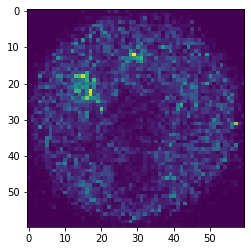

In [50]:
plt.imshow(the_images[('no_TOF', 500000)][6,:,:,29]);

In [51]:
def imshow_slice_integrated_along_z(ax, nc, name, it, z_slice):
    if it < 1:
        it = 1
    image_slice = the_images[conf_nc(conf=name, nc=nc)][int(it/save_every-1),:,:,z_slice]
    im_integrated_along_z = np.sum(image_slice, axis=2).transpose()
    fig0 = ax.imshow(im_integrated_along_z, origin='lower')
    title = f'{name}'
    ax.set_title(title, fontsize=17)
    ax.set_xlabel('X (mm)', fontsize=15)
    ax.set_ylabel('Y (mm)', fontsize=15)
    #fig.colorbar(fig0, ax=ax, label='Events')

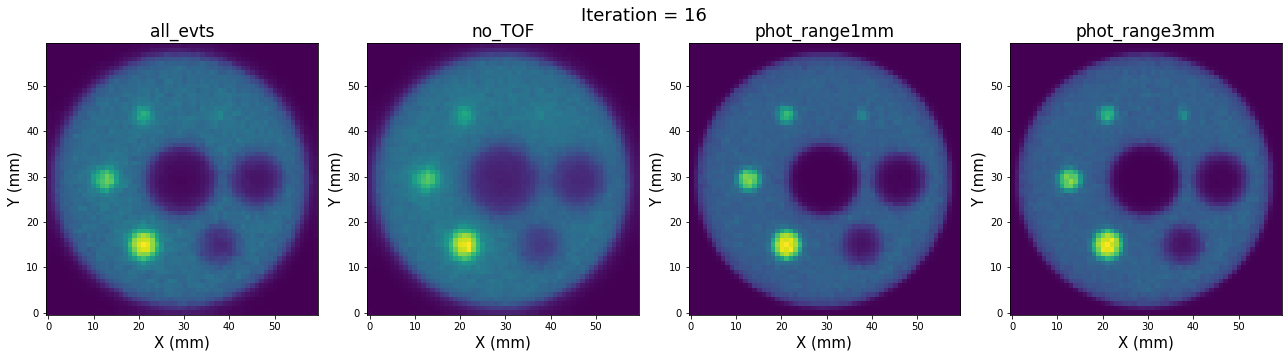

In [53]:
it       = 15
z_slice  = slice(25,35)
fig, axs = plt.subplots(1,4, figsize=(18, 5))
fig.suptitle(f'Iteration = {it+1}', fontsize=18)
sel_coincs = [20000000, 20000000, 20868917, 20000000]
for ax, name, nc in zip(axs.flatten(), confs.keys(), sel_coincs):
    imshow_slice_integrated_along_z(ax, nc=nc, name=name, it=it, z_slice=z_slice)
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

### Images parameters:

In [54]:
sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6

hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]
all_radii   = hot_radii + cold_radii

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]

x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

radii  = hot_radii  + cold_radii
angles = hot_angles + cold_angles

In [55]:
num_hot     = 4
num_cold    = 2
num_spheres = num_hot + num_cold

sph_conf_nc = namedtuple('sph_conf_nc', 'sph, conf, nc')
snr_err     = namedtuple('snr_err'    , 'snrs, errs')


def get_snrs(images, conf_nc, n_sph):
    calculate_snrs_and_errs = lambda images: fomf.snr3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                        bckg_radius, phi0, phi_step, n_phi, 
                                                        x_size, y_size, z_size,
                                                        x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_snrs_and_errs, images[conf_nc]))
    snrs = [r[0] for r in all_images]
    errs = [e[1] for e in all_images]
    print(conf_nc, n_sph)
    return snr_err(snrs=snrs, errs=errs)

snrs = {sph_conf_nc(sph=n_sph, conf=name, nc=nc) :
        get_snrs(the_images, conf_nc(conf=name, nc=nc), n_sph)
        for name, (_, _, coincs, _) in confs.items()
        for nc   in coincs
        for n_sph in range(num_spheres)}

In [57]:
snrs;

In [58]:
from typing import Sequence
from typing import Dict

sel_n_iter = 16
def plot_snr_sphs_nc(snrs:    Dict[sph_conf_nc, snr_err], 
                     spheres: Sequence[int], 
                     conf:    str,
                     n_coinc: Sequence[float]):
    it_wanted = int(sel_n_iter/save_every)-1
    for n_sphere in spheres:
        sphs     = np.array([snrs[sph_conf_nc(sph  = n_sphere,
                                              conf = conf,
                                              nc   = nc)].snrs[it_wanted:it_wanted+1]
                             for nc in n_coinc])#.reshape(1,8)[0]

        sphs_err = np.array([snrs[sph_conf_nc(sph  = n_sphere,
                                              conf = conf,
                                              nc   = nc)].errs[it_wanted:it_wanted+1]
                             for nc in n_coinc])#.reshape(1,8)[0]

        lab    = f'sph{n_sphere}, ({all_radii[n_sphere]} rad, {conf})'
        plt.errorbar(x       = np.array(n_coinc),
                     y       = sphs,
                     yerr    = sphs_err,
                     xerr    = None,
                     marker  = 's', 
                     capsize = 3,
                     label   = lab)

## SNR vs number of coincidences

/software/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


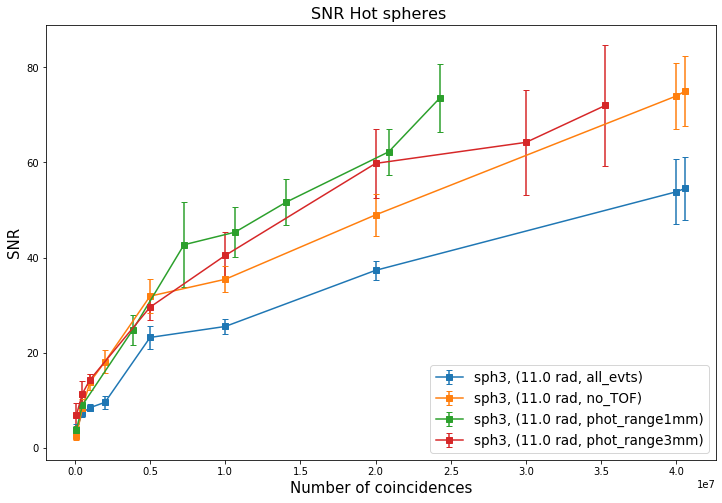

In [60]:
plt.figure(figsize=(12,8))
for name, (_, _, coincs, _) in confs.items():
    plot_snr_sphs_nc(snrs, range(3,4), name, n_coinc=coincs)
plt.title(f'SNR Hot spheres ', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=4, fontsize=13.5, ncol=1);

/software/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


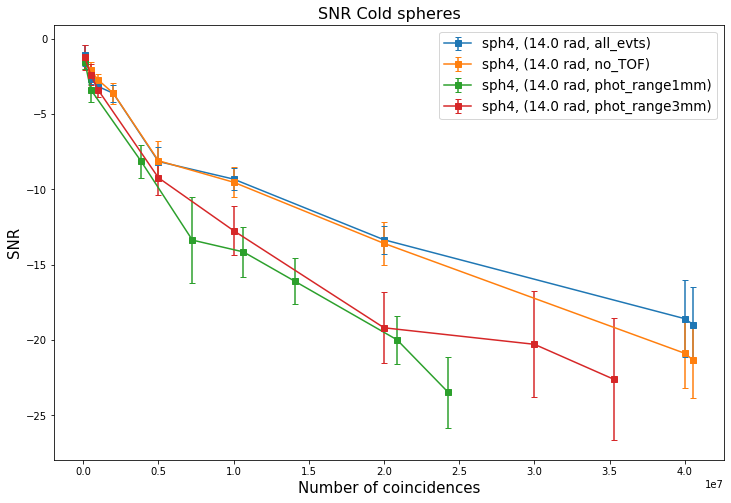

In [63]:
plt.figure(figsize=(12,8))
for name, (_, _, coincs, _) in confs.items():
    plot_snr_sphs_nc(snrs, range(4, 5), name, n_coinc=coincs)
plt.title(f'SNR Cold spheres', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=1, fontsize=13.5, ncol=1);

## CRC vs number of coincidences:

In [65]:
crc_err = namedtuple('crc_err', 'crcs, errs')
sig_intensity  =  4
bckg_intensity =  1

def get_crcs(images, conf_nc, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_hot3d(images, sig_intensity, bckg_intensity, 
                                                            radii[n_sph], radial_pos, angles[n_sph], 
                                                            bckg_radius, phi0, phi_step, n_phi, 
                                                            x_size, y_size, z_size,
                                                            x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[conf_nc]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(conf_nc, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs = {sph_conf_nc(sph=n_sph, conf=name, nc=nc):
        get_crcs(the_images, conf_nc(conf=name, nc=nc), n_sph)
        for name, (_, _, coincs, _) in confs.items()
        for nc   in coincs
        for n_sph in range(4)}

In [66]:
def get_crcs_cold(images, conf_nc, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_cold3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                             bckg_radius, phi0, phi_step, n_phi, 
                                                             x_size, y_size, z_size,
                                                             x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[conf_nc]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(conf_nc, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs_cold = {sph_conf_nc(sph=n_sph, conf=name, nc=nc):
             get_crcs_cold(the_images, conf_nc(conf=name, nc=nc), n_sph)
             for name, (_, _, coincs, _) in confs.items()
             for nc   in coincs
             for n_sph in range(4,6)}

In [71]:
def plot_crc_sphs_nc(crcs:    Dict[sph_conf_nc, crc_err], 
                     spheres: Sequence[int], 
                     conf:    str,
                     n_coinc: Sequence[float]):
    it_wanted = int(sel_n_iter/save_every)-1
    for n_sphere in spheres:
        sphs     = np.array([crcs[sph_conf_nc(sph  = n_sphere,
                                              conf = conf,
                                              nc   = nc)].crcs[it_wanted:it_wanted+1]
                             for nc in n_coinc])#.reshape(1,8)[0]

        sphs_err = np.array([crcs[sph_conf_nc(sph  = n_sphere,
                                              conf = conf,
                                              nc   = nc)].errs[it_wanted:it_wanted+1]
                             for nc in n_coinc])#.reshape(1,8)[0]

        lab    = f'sph{n_sphere}, ({all_radii[n_sphere]} rad, {conf})'
        plt.errorbar(x       = np.array(n_coinc),
                     y       = sphs,
                     yerr    = sphs_err,
                     xerr    = None,
                     marker  = 's', 
                     capsize = 3,
                     label   = lab)

/software/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


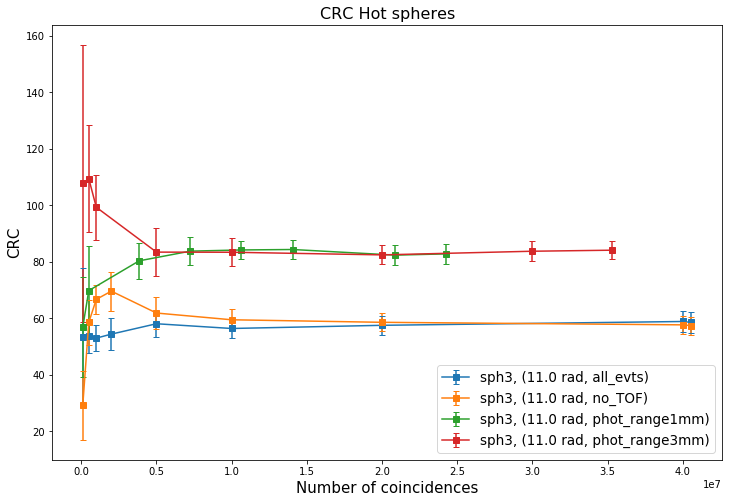

In [74]:
plt.figure(figsize=(12,8))
for name, (_, _, coincs, _) in confs.items():
    plot_crc_sphs_nc(crcs, range(3,4), name, n_coinc=coincs)
plt.title(f'CRC Hot spheres', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('CRC', fontsize=15)
plt.legend(loc=4, fontsize=13.5, ncol=1);

/software/miniconda/envs/IC-3.7-2020-06-16/lib/python3.7/site-packages/ipykernel_launcher.py:24: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.


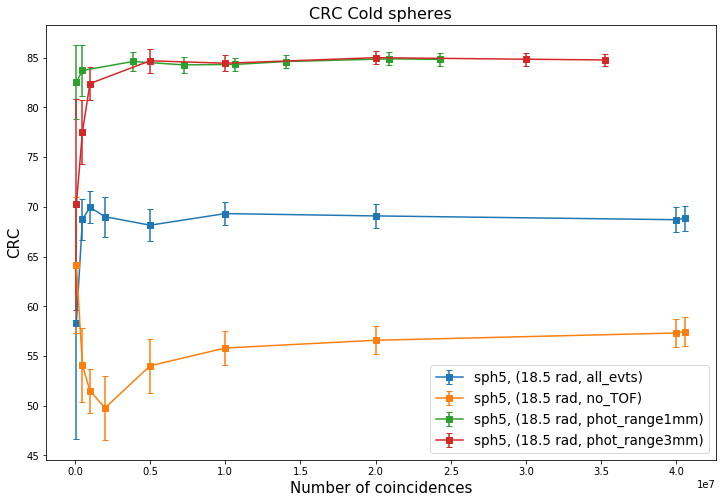

In [78]:
plt.figure(figsize=(12,8))
for name, (_, _, coincs, _) in confs.items():
    plot_crc_sphs_nc(crcs_cold, range(5,6), name, n_coinc=coincs)
plt.title(f'CRC Cold spheres', fontsize=16)
plt.xlabel('Number of coincidences', fontsize=15)
plt.ylabel('CRC', fontsize=15)
plt.legend(loc=4, fontsize=13.5, ncol=1);